In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import torch
import yaml

from explainnn.dataloader import load_test_image
from explainnn.main import get_causal_connections, visualize_attributions, get_sample_explanations, compute_baseline_attr
from explainnn.definitions import CONFIG_FILE, ATTR_DATASET, OUTPUT_DIR
from explainnn.utils import load_model

with open(CONFIG_FILE, 'r') as f:
    args = yaml.load(f, Loader=yaml.FullLoader)
device = torch.device('cpu')
args['dataset_name'] = 'MNIST'
model = load_model(
    model_name='LeNet',
    dataset_name=args['dataset_name'],
    n_classes=ATTR_DATASET[args['dataset_name']]['n_classes'],
    in_channels=ATTR_DATASET[args['dataset_name']]['n_channels'],
    device=device
)

# Interventional Explanations of Neural Networks

## Generate/Load causal graph

In [2]:
args['learn_explainer'] = False
causal_path, explainer = get_causal_connections(args, model, device=device)

In [3]:
for k in causal_path.keys():
    if k=='label':
        print(f'Target class : {causal_path[k]}')
    else:
        print(f'{k} : {causal_path[k][0]}')

fc3 : tensor([ 9, 27, 28, 31, 32, 34, 47, 68, 70, 71, 76, 80, 81])
fc2 : tensor([ 0,  8, 34, 52, 69, 70, 81, 83])
fc1 : tensor([ 0,  4,  6,  7,  8, 10, 13, 14])
conv2 : tensor([0, 2, 4])
conv1 : [0]
Target class : 3


## Analyze attributions

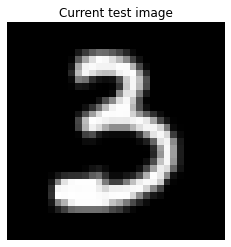

In [4]:
test_image, label_idx = load_test_image(args['dataset_name'], args['target_idx'])
fig, ax = plt.subplots(1,1)
if len(test_image.shape)>2:
    test_image_vis = test_image.mean(1)
else:
    test_image_vis = test_image

ax.imshow(test_image_vis.squeeze(), cmap='gray')
ax.set_title('Current test image')
ax.axis('off');

In [ ]:
args['layer_name']='conv2'
attributions = get_sample_explanations(args, test_image, causal_path, explainer)
vis = visualize_attributions(args, test_image, attributions=attributions)


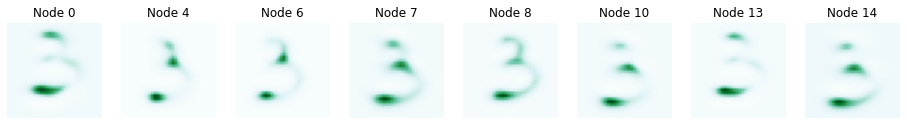

In [6]:
fig, ax = plt.subplots(1, len(vis.keys())-1, figsize=((len(vis.keys())-1)*2,2))
i = 0
for k in vis.keys():
    if k != 'origin_image':
        ax[i].axis('off')
        ax[i].set_title(f'Node {k}')
        ax[i].imshow(vis[k], cmap='BuGn')
        i+=1


## Baseline attributions

In [ ]:
baseline_attr = compute_baseline_attr(args, model, test_image,  device=device)

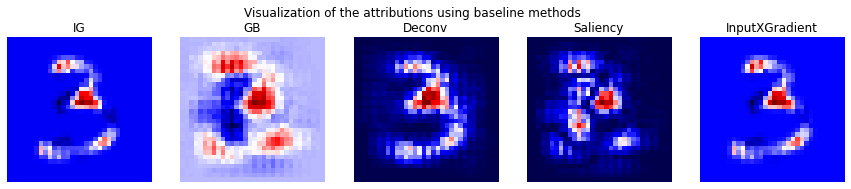

In [16]:
fig2, ax2 = plt.subplots(1, len(baseline_attr.keys()), figsize=((len(baseline_attr.keys()))*3,3))
for i, k in enumerate(baseline_attr.keys()):
    ax2[i].imshow(baseline_attr[k].detach().squeeze().numpy(), cmap='seismic')
    ax2[i].axis('off')
    ax2[i].set_title(k)
fig2.suptitle(f'Visualization of the attributions using baseline methods');

## Evaluate attributions

In [9]:
IORF_df = pd.read_csv(OUTPUT_DIR.joinpath('evaluation_metrics', args['model_name'], 'IORF_metric.csv'), index_col=0)
LE_df = pd.read_csv(OUTPUT_DIR.joinpath('evaluation_metrics', args['model_name'], 'LipschitzEstimate_metric.csv'),index_col=0)

In [10]:
IORF_df.describe()

,metric
count,17.000000
mean,37.935726
std,3.920449
min,29.430954
25%,36.177762
50%,38.500291
75%,39.411378
max,46.295366


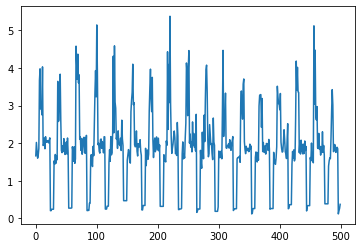

In [11]:
LE_df.describe()
plt.plot(LE_df['metric']);

## Graph stability

In [12]:
with open(OUTPUT_DIR.joinpath(args['dataset_name'], f'class_{args["target_idx"]}', 'stability.pkl'), 'rb') as f:
    stab_data = pickle.load(f)

In [13]:
all_nodes = []
for beta in stab_data.keys():
    all_nodes_tmp = []
    for elt in stab_data[beta]:
        if len(elt)>0:
            all_nodes_tmp.append(torch.as_tensor(elt[0]))
        else :
            all_nodes_tmp.append(torch.as_tensor(elt))

    all_nodes.append(torch.cat(all_nodes_tmp))

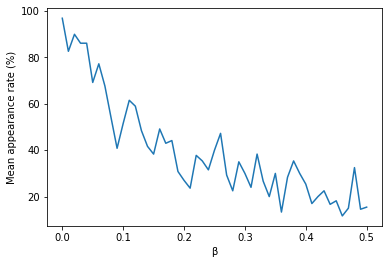

In [14]:
y1 = []
for i, k in enumerate(stab_data.keys()):
    y1.append(torch.unique(all_nodes[i], return_counts=True)[1].float().mean())
plt.plot(stab_data.keys(), torch.tensor(y1)*10)
plt.ylabel('Mean appearance rate (%)')
plt.xlabel('β');

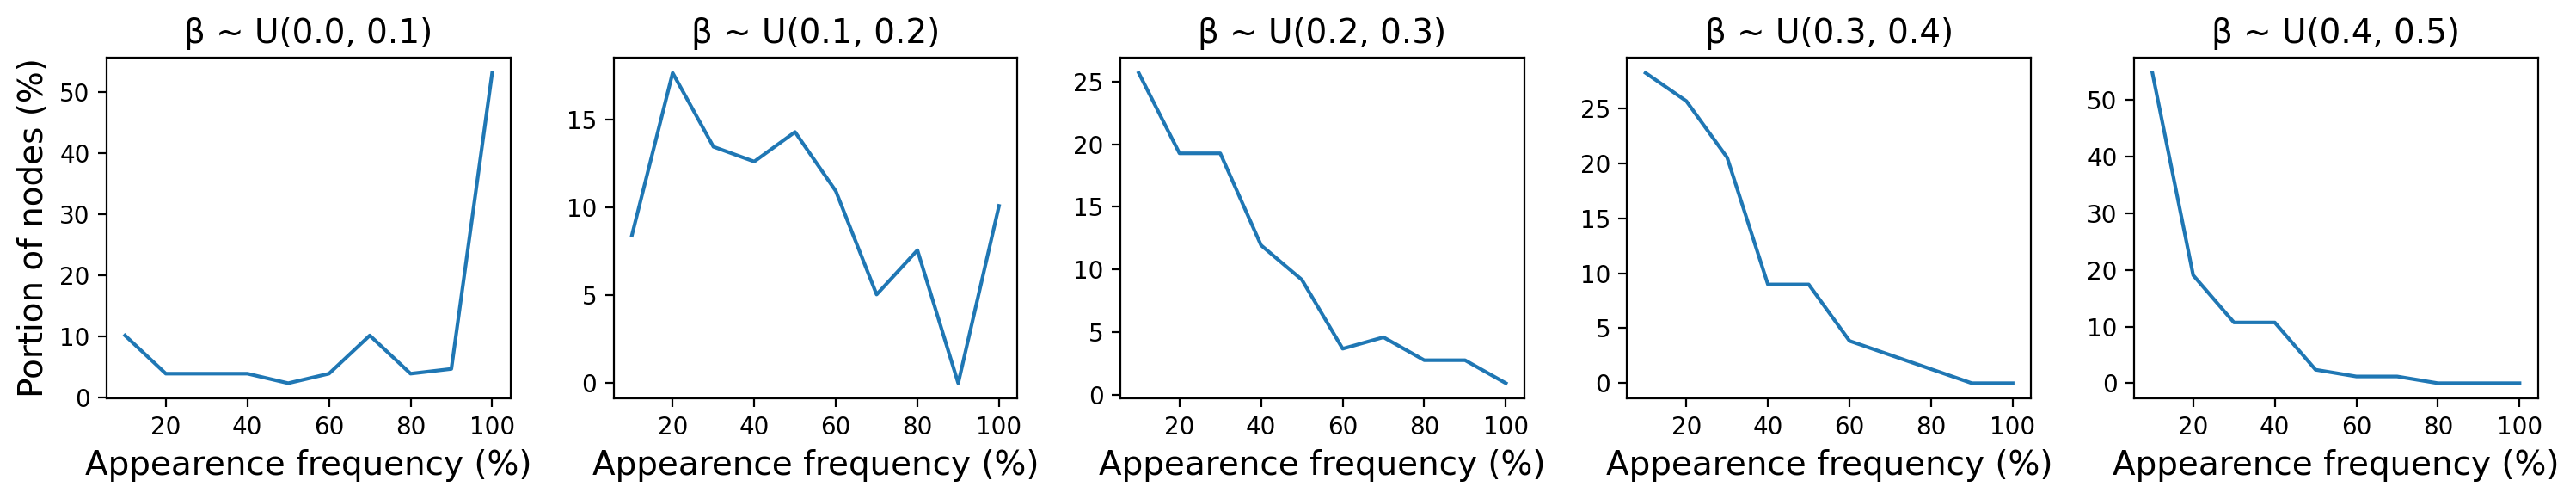

In [15]:
y2 = []
fig, ax = plt.subplots(1, 5,figsize=(15,3),  dpi=200)

for i in range(0, len(all_nodes)-1, 10):
    tmp = np.array([])
    for j in range(10):
        tmp = np.concatenate((tmp, torch.unique(all_nodes[i+j], return_counts=True)[1].numpy()))
    x,y = np.unique(tmp, return_counts=True)
    new_x = np.array(range(1,11))
    new_y = np.zeros(len(new_x))
    for k in range(len(new_x)):
        if new_x[k] in x:
            new_y[k] = y[np.where(x == new_x[k])]
    ax[int(i/10)].plot(new_x*10,new_y*100/new_y.sum() if new_y.sum()>0 else new_y)
    ax[int(i/10)].set_xlabel('Appearence frequency (%)', fontsize=14)
    ax[int(i/10)].set_title(f'β ~ U({i/100}, {(i+10)/100})', fontsize=14)

    # Play with the scale
    #ax[int(i/10)].semilogy()
ax[0].set_ylabel('Portion of nodes (%)', fontsize=14)
plt.tight_layout();